In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import time
import tqdm
from datetime import datetime
from google.cloud.logging import DESCENDING, Client
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.family'] = 'monospace'

In [83]:
lhh = pd.read_csv('last13.csv', delimiter='|', 
                  names=['slot','received_at','eligible_at','optimistic_submission','decode_duration',
                         'prechecks_duration','simulation_duration','redis_update_duration',
                         'total_duration','sim_success'])
lhh.head()

,slot,received_at,eligible_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,sim_success
0,6274009,2023-04-2121:22:10.874361,2023-04-2121:22:10.976478,f,6490,2763,78705,14164,102124,t
1,6274009,2023-04-2121:22:11.227392,2023-04-2121:22:11.248353,t,8317,2320,10,10314,20963,t
2,6274009,2023-04-2121:22:11.499971,2023-04-2121:22:11.520116,t,6930,2271,11,10932,20147,t
3,6274009,2023-04-2121:22:11.706185,2023-04-2121:22:11.731431,t,10329,2163,11,12744,25248,t
4,6274009,2023-04-2121:22:11.453326,2023-04-2121:22:11.481039,t,12990,3521,14,11189,27716,t


In [84]:
diffs = (lhh['decode_duration'] + lhh['prechecks_duration'] + lhh['simulation_duration'] + \
 lhh['redis_update_duration'] - lhh['total_duration'])
diffs.mean(), diffs.min(), diffs.max()

(-1.5030620619988635, -3, 0)

In [85]:
len(lhh[lhh['optimistic_submission']=='t']), len(lhh[lhh['optimistic_submission']=='f'])

(12783, 3056)

In [86]:
opts = lhh[lhh['optimistic_submission']=='t']
nops = lhh[lhh['optimistic_submission']=='f']

In [87]:
printdf(opts)

decode\_duration & 10194 & 23477 & 97776 & 393434 \\
prechecks\_duration & 2578 & 3421 & 8032 & 274761 \\
simulation\_duration & 10 & 12 & 15 & 39 \\
redis\_update\_duration & 8783 & 13343 & 33663 & 1264906 \\
\hline
\textbf{total\_duration} & \textbf{23916} & \textbf{66586} & \textbf{125868} & \textbf{1797524} \\


In [67]:
printdf(nops)

decode\_duration & 16043 & 59141 & 201531 & 2353783 \\
prechecks\_duration & 3195 & 18372 & 157218 & 774498 \\
simulation\_duration & 120175 & 176396 & 324453 & 1827215 \\
redis\_update\_duration & 10712 & 42934 & 477523 & 2713960 \\
\hline
\textbf{total\_duration} & \textbf{177788} & \textbf{354307} & \textbf{1159703} & \textbf{5423011} \\


prechecks_duration
redis_update_duration
total_duration

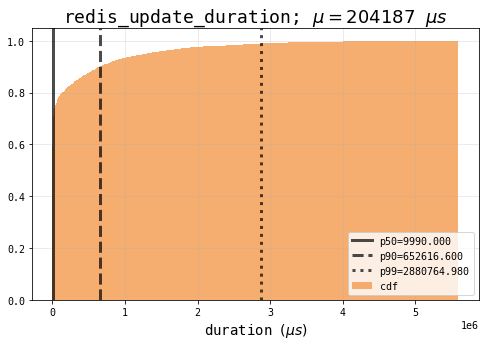

In [61]:
f, ax = plt.subplots(figsize=(8,5))
# key = 'prechecks_duration'
key = 'redis_update_duration'
# key = 'total_duration'
percs = [(int(i*100), np.quantile(opts[key], i)) for i in [.50, .90, .99]]

ax.hist(opts[key], bins=500, color='sandybrown', alpha=0.9, cumulative=1,
        density=True, label='cdf')
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.3f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)

ax.set_xlabel('duration $(\mu s)$', size=14)
ax.set_title('{}; $\mu={:0.0f}$ $\mu s$'.format(key, opts[key].mean()), size=18)
plt.legend(loc=4)
plt.show()

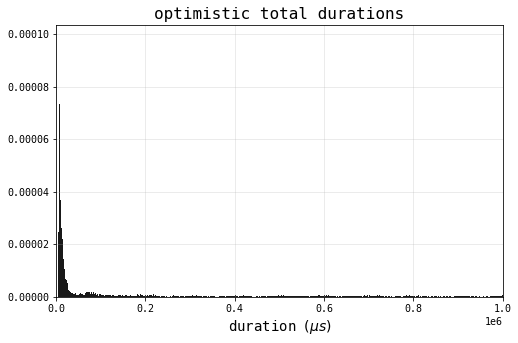

In [28]:
f, ax = plt.subplots(figsize=(8,5))
bins = np.histogram(opts_clipped['redis_update_duration'], bins=500)[1]
ax.hist(opts_clipped['redis_update_duration'], bins=bins, color='black', alpha=0.9, density=True)

ax.set_xlim(0, int(1e6))
# ax.legend(loc=0)
ax.set_xlabel('duration $(\mu s)$', size=14)
ax.set_title('optimistic total durations', size=16)
# ax.set_title('total duration; $\mu = {:0.0f}$'.format(nopts['total_duration'].values.mean()), size=18)
plt.show()

In [14]:
def printdf(df):
    print('decode\_duration & ', end='')
    st = ''
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['decode_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('prechecks\_duration & ', end='')
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['prechecks_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('simulation\_duration & ', end='')
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['simulation_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('redis\_update\_duration & ', end='')
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['redis_update_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('\\hline')
    print('\\textbf{total\_duration} & ', end='')
    for i in [50, 75, 90, 99]:
        st += '\\textbf{{{}}}'.format(str(int(np.percentile(df['total_duration'], i))))
        st += " & "
    print(st[:-3] + ' \\\\')

In [12]:
len(lhh[lhh['optimistic_submission']=='t'])

45288

In [9]:
printdf(lhh[lhh['optimistic_submission']=='t'])

decode\_duration & 13205 & 87762 & 221634 & 998024 \\
prechecks\_duration & 3356 & 64640 & 279932 & 981432 \\
simulation\_duration & 375 & 21847 & 161235 & 765575 \\
redis\_update\_duration & 16022 & 314586 & 1323086 & 3977412 \\
\hline
\textbf{total\_duration} & \textbf{58891} & \textbf{569184} & \textbf{2219318} & \textbf{5232605} \\
